### In this script, we load in the TG data, then rotate, crop the picture to make it at a suitable size for autoencoder. 
## Our original data was a .asc file, which is a common format for geographical data. Using Raterio, we can transfer it to a Numpy Array, which would be used in our autoencoder


In [2]:
# import necessary packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [3]:
# load in the topology np array
loaded_up = np.load('up_data.npy')
loaded_down = np.load('down_data.npy')
up_data = np.transpose(loaded_up, (2, 0, 1))
down_data = np.transpose(loaded_down, (2, 0, 1))

### We have topology of different depth, here we choose the 001m. We choose so because it has the most clear pattern in the bed.

In [18]:
#we choose the 001m topology of upstream as example
arr = up_data[0]


### Our topology is on a large piece of glacier. It has irregular shape, titled from horizontal line, and surrounded by white blank space. To reduce the impact of outside blanks, we need to find a
### rectangle as small as possible to contain the glacier, then we rotate the rectangle so the value in each pixel could fit in a x-y axis.

### To do so, we consider using PCA as a first step. The first component of PCA can help us decide the angle of the two main components are from horizontal line. And use it, we can have a first step of cropping and rotating of our glacier.


## Step 1: Find the bounding box that contains the object
The script starts by replacing any NaN values in the array with 1. It then finds the coordinates of non-NaN values (pixels that are part of the object), and calculates the minimum and maximum values of these coordinates to identify the bounding box.

In [19]:

# Replace nan values with a value outside the range of pixel values
arr[np.isnan(arr)] = 1
# Get the coordinates of pixels that are not -1 (our placeholder for nan)
non_nan_coords = np.argwhere(arr != 1)
# Get the bounding box coordinates
x_min, y_min = np.min(non_nan_coords, axis=0)
x_max, y_max = np.max(non_nan_coords, axis=0)


## Step 2: Estimate the tilt angle
Next, the script uses Principal Component Analysis (PCA) to estimate the tilt angle of the object. The PCA function is fitted to the non-NaN coordinates. The angle is then calculated as the arctangent of the slope of the first principal component.

## PCA for Orientation Estimation
In this case, PCA is used to identify the main direction in which the object is spread in the image. The first principal component, or the direction of maximum variance, will correspond to the long axis of the object. The angle of this axis from the horizontal axis gives us the tilt angle of the object.

In these lines, we create an instance of the PCA class with n_components=2. This means we want to find the 2D plane on which to project our 2D data. The fit() method is then used to calculate the principal components.

The components_ attribute of the fitted PCA object gives the principal components of the dataset. pca.components_[0] returns the first principal component. The np.arctan2(*pca.components_[0]) function is used to calculate the arctangent of the y/x ratio of the first principal component, giving the angle of the first principal component in radians. Multiplying by 180 / np.pi converts this angle from radians to degrees.

It's important to note that np.arctan2(y, x) gives the angle from the positive x-axis to the point (x, y) in the Cartesian plane, which is the reason why we use np.arctan2(*pca.components_[0]) instead of np.arctan(pca.components_[0][1] / pca.components_[0][0]).

This gives us the orientation of the object in the image in degrees, which can then be used to rotate the image and align the object along the horizontal axis.

In [ ]:

pca = PCA(n_components=2)
pca.fit(non_nan_coords)
# The angle is the arctangent of the slope of the first principal component
angle = np.arctan2(*pca.components_[0]) * 180 / np.pi


## Step 3: Rotate the image to normal direction
The rotation center is calculated as the center of the bounding box. A rotation matrix is then calculated using cv2.getRotationMatrix2D, which takes as arguments the rotation center, the angle of rotation, and the scaling factor (1 in this case). The cv2.warpAffine function is then used to apply the rotation matrix to the array.

In [ ]:
# The rotation center is the center of the bounding box
rotation_center = ((x_max + x_min) / 2, (y_max + y_min) / 2)
rotation_matrix = cv2.getRotationMatrix2D(rotation_center, angle, 1)
rotated_arr = cv2.warpAffine(arr, rotation_matrix, arr.shape[1::-1])


## Step 4: Crop the image to just the bounding box
Finally, the image is cropped to the bounding box dimensions.

In [ ]:

# Step 4: Crop the image to just the bounding box
cropped_arr = rotated_arr[x_min:x_max+1, y_min:y_max+1]



### However, PCA does not work perfectly, we still need to manually make adjustments.

In [21]:
# we find out that PCA cannot give the smallest rectangle as possible, so we manually choose the limit line to cut it
non_empty = []
for i in range(1107):
    if cropped_arr[i].min() < 0:
        non_empty.append(i)

col_non_empty = []
for j in range(2091):
    if cropped_arr.T[j].min() < 0:
        col_non_empty.append(j)
    

### We find out the right edge has been cut well. Now we define the top, bottom and left edge of our data.

In [23]:
top = non_empty[0]
bottom = non_empty[-1]
left = col_non_empty[0]

### Next part is very tricky. In autoencoders, we need to take samples from data and form different layers. Some algotithm take samples by 2x2x2, some by 2x2, which means sometimes, the pixels, the number of rows and columns sometimes has to be dividible by 8, sometimes 4.

In [46]:
new_arr=cropped_arr[top:bottom,left-6:]

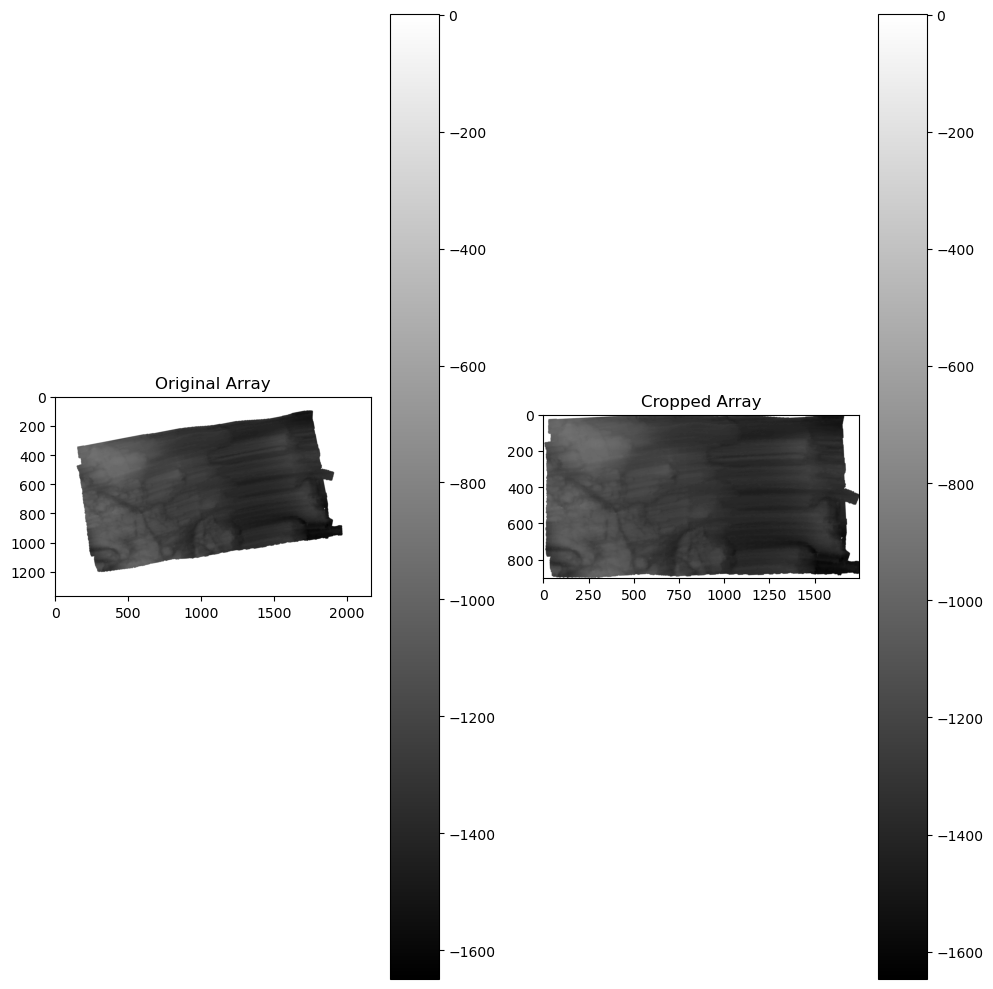

In [47]:
# Plotting original array
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.title('Original Array')
plt.imshow(arr, cmap='gray')  # Assuming the array values are grayscale
plt.colorbar()

# Plotting cropped array
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.title('Cropped Array')
plt.imshow(new_arr, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

In [48]:
new_arr.shape

(904, 1744)

In [49]:

np.save('new_arr.npy', new_arr)


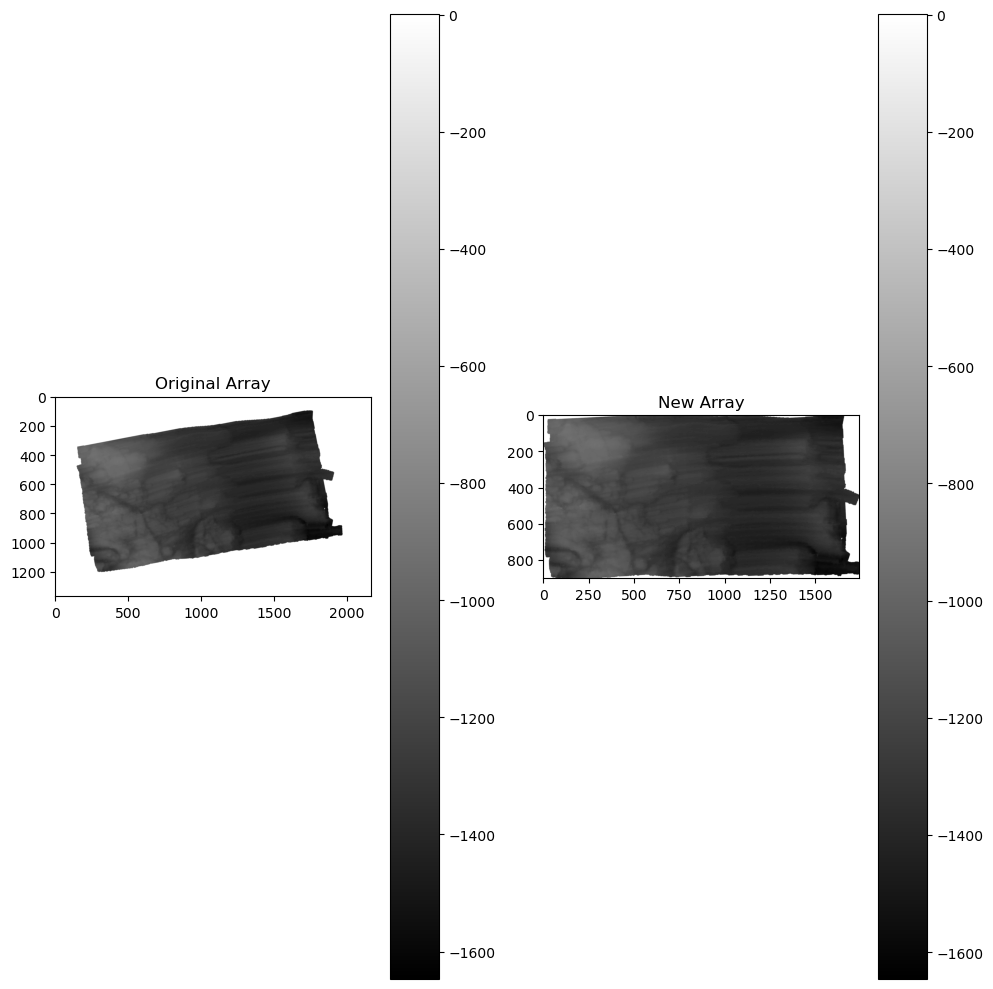

In [59]:
# Plotting original array
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.title('Original Array')
plt.imshow(arr, cmap='gray')  # Assuming the array values are grayscale
plt.colorbar()

# Plotting cropped array
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.title('New Array')
plt.imshow(new_arr, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()